# Load Libraries

In [19]:
# basic data science stack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.metrics import confusion_matrix
# tensorflow/keras for modeling
import tensorflow as tf
from tensorflow.keras import models, layers, losses, utils, callbacks, preprocessing

# pickle for saving/loading
import pickle

# Load Data

In [2]:
with open('../Data/Cleaned/X_train.pickle', 'rb') as file:
    X_train = pickle.load(file)

with open('../Data/Cleaned/X_test.pickle', 'rb') as file:
    X_test = pickle.load(file)

with open('../Data/Cleaned/y_train.pickle', 'rb') as file:
    y_train = pickle.load(file)

with open('../Data/Cleaned/y_test.pickle', 'rb') as file:
    y_test = pickle.load(file)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(14034, 150, 150, 3) (14034,) (3000, 150, 150, 3) (3000,)


# Create Basic CNN

In [3]:
CNN_v1 = models.Sequential()
CNN_v1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
CNN_v1.add(layers.MaxPooling2D((2, 2)))
CNN_v1.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNN_v1.add(layers.MaxPooling2D((2, 2)))
CNN_v1.add(layers.Conv2D(128, (3, 3), activation='relu'))
CNN_v1.add(layers.MaxPooling2D((2, 2)))
CNN_v1.add(layers.Flatten())
CNN_v1.add(layers.Dense(64, activation='relu'))
CNN_v1.add(layers.Dense(6, activation='softmax'))

CNN_v1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 36992)             0

# Compile and Fit Basic CNN

In [4]:
CNN_v1.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics = 'acc')

In [5]:
results_CNN_v1 = CNN_v1.fit(
    X_train, 
    y_train,
    batch_size = 50,
    epochs = 10, 
    validation_data=(X_test, y_test), 
    verbose = 2)

Epoch 1/10
281/281 - 17s - loss: 0.9602 - acc: 0.6314 - val_loss: 0.7248 - val_acc: 0.7290
Epoch 2/10
281/281 - 8s - loss: 0.6121 - acc: 0.7770 - val_loss: 0.6017 - val_acc: 0.7810
Epoch 3/10
281/281 - 8s - loss: 0.4870 - acc: 0.8244 - val_loss: 0.6479 - val_acc: 0.7547
Epoch 4/10
281/281 - 8s - loss: 0.3791 - acc: 0.8631 - val_loss: 0.5434 - val_acc: 0.8193
Epoch 5/10
281/281 - 8s - loss: 0.2693 - acc: 0.9074 - val_loss: 0.5750 - val_acc: 0.8130
Epoch 6/10
281/281 - 8s - loss: 0.1765 - acc: 0.9383 - val_loss: 0.6169 - val_acc: 0.8150
Epoch 7/10
281/281 - 8s - loss: 0.1290 - acc: 0.9563 - val_loss: 0.7672 - val_acc: 0.7933
Epoch 8/10
281/281 - 8s - loss: 0.0828 - acc: 0.9732 - val_loss: 0.8241 - val_acc: 0.8200
Epoch 9/10
281/281 - 8s - loss: 0.0626 - acc: 0.9815 - val_loss: 0.8517 - val_acc: 0.8147
Epoch 10/10
281/281 - 8s - loss: 0.0533 - acc: 0.9855 - val_loss: 0.9928 - val_acc: 0.7980


# Evaluate Basic CNN

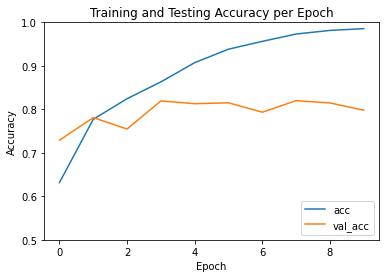

In [6]:
def accuracy_line_plot(modelresults, metric, validation_metric):
    """Create line plot comparing metrics for the training and validation sets"""
    
    plt.plot(modelresults.history[metric], label=metric)
    plt.plot(modelresults.history[validation_metric], label = validation_metric)
    plt.title("Training and Testing Accuracy per Epoch")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')

accuracy_line_plot(results_CNN_v1, 'acc', 'val_acc')

The training accuracy improved all the way up to 98.4% in Epoch 9 on the training set, however testing accuracy peaked at 82.6% in epoch 4.

# Which Classes Are Being Missed Most?

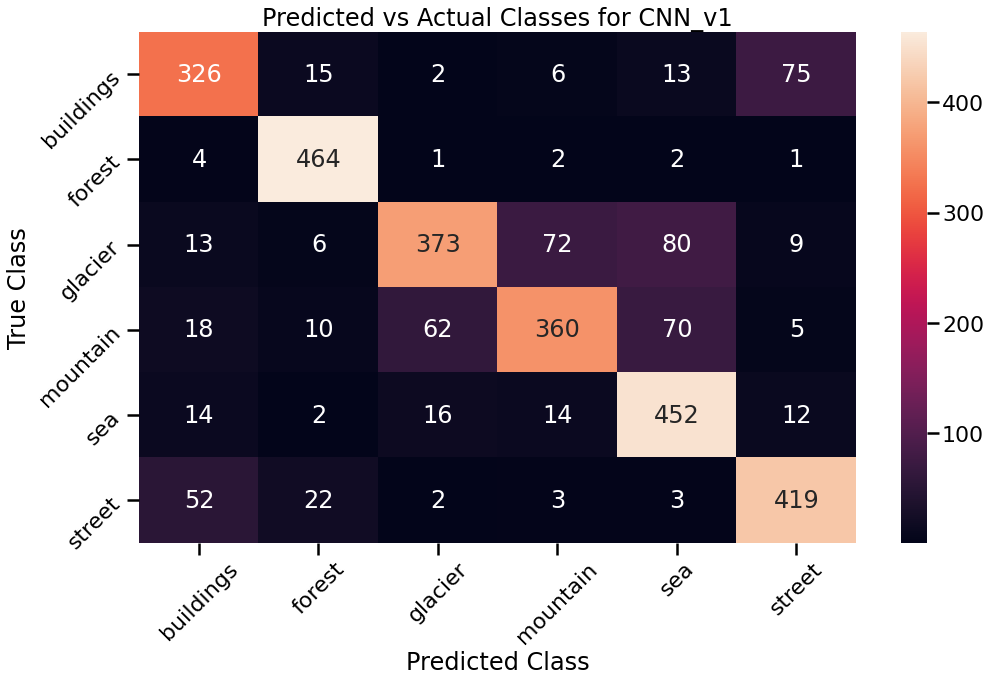

In [11]:
def create_display_confusion_matrix(model, X, y, class_labels):
    """Create and display a confusion matrix for the purpose of identifying classes that have been """
    y_pred = np.argmax(model.predict(X), axis = -1)
    cm = confusion_matrix(y, y_pred)
    
    sns.set_context('poster')
    fig, ax = plt.subplots(figsize = (15,10))
    sns.heatmap(cm, annot=True, fmt='.0f', ax = ax)
    ax.set_title('Predicted vs Actual Classes for CNN_v1')
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('True Class')
    ax.set_xticklabels(labels=class_labels, rotation = 45)
    ax.set_yticklabels(labels=class_labels, rotation = 45)
    plt.tight_layout()
    plt.show()
    
labels = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

create_display_confusion_matrix(CNN_v1, X_test, y_test, class_labels)

Our model has trouble with the following:
1. Buildings being predicted as streets/streets being predicted as buildings
2. Glaciers being confused with mountains/mountains being predicted as glaciers
3. Glaciers and mountains being predicted as sea

Logically, all of these mistakes make sense. Buildings and streets have similar color schemes, and similar shapes since there are likely edges of buildings within the street pictures. Glaciers in many cases likely look like mountains made out of ice. It may seem weird that a mountain or glacier would look like the sea, but when you think about the colors/shapes/structures within the photos it starts to make sense. 

# Save Model

In [13]:
CNN_v1.save('../Models/CNN_v1')

INFO:tensorflow:Assets written to: ../Models/CNN_v1\assets


# Model Improvement

There are many ways to improve/tune a neural network, but to start I'd like to explore two of the biggest ones:
1. Use more data
2. Train for a larger number of epochs

Computer vision problems are notorious for requiring a large amount of data to create truly accurate models. Currently our training dataset is limited to ~14k images, which is ~2300 per class. This lack of data may be limiting our models potential. 

While we can't go out and collect additional data, we can use some tricks to generate additional data from our current dataset.

# Image Augmentation

Below I will use the Keras ImageDataGenerator class to perform image augmentation on this dataset. While image augmentation can be useful for making your model more robust to different image types, we need to be sure that we are creating additional relevant information, and not additional irrelevant information. When selecting different augmentation methods it is important to have justification for why we are using that method, and why we are selecting the specific parameter value for that method. In some cases, I may test multiple models with different levels of augmented data to see which works better.

1. Rotation Range: I've decided to use rotation but only to a mild degree (up to 20 degrees). This is because most of our images are of environments that are unlikely to be pictured upside down or rotated very much at all. For example, when have you ever seen a picture of a mountain or a building on its side? The small rotation amount should help deal with pictures that are taken at slightly-off rotations.

2. Width_shift_range: I've decided to use a width_shift_range of somewhere between 0.2 and 0.4. I think this may help with scenes that have the mountain/building/street/etc not directly in the middle of the image.

4. Height_shift_range: I'm not sure whether to use this or not since I think it may cut out the peak of the mountains/glaciers/buildings. I'll try a mild amount of 0.2.

5. Horizontal_flip: I'm using horizontal shift but not vertical flip because flipping a mountain or building or glacier upside down does not really make sense.

6. Brightness_range: it's very reasonably that outdoor pictures would be taken under different lighting conditions so I'll use a brightness range to account for that.

7. Zoom_range: I'll likely test zoom ranges of between 0.2 and 0.4.

8. Shear_range: I'll test shear ranges of between 0.2 and 0.4.

In [17]:
datagen = preprocessing.image.ImageDataGenerator(
    featurewise_center=True, 
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    zoom_range=0.2,
    shear_range=0.2  
)


94/94 - 1s - loss: 0.9928 - acc: 0.7980
Restored model, accuracy: 79.80%
(3000, 6)


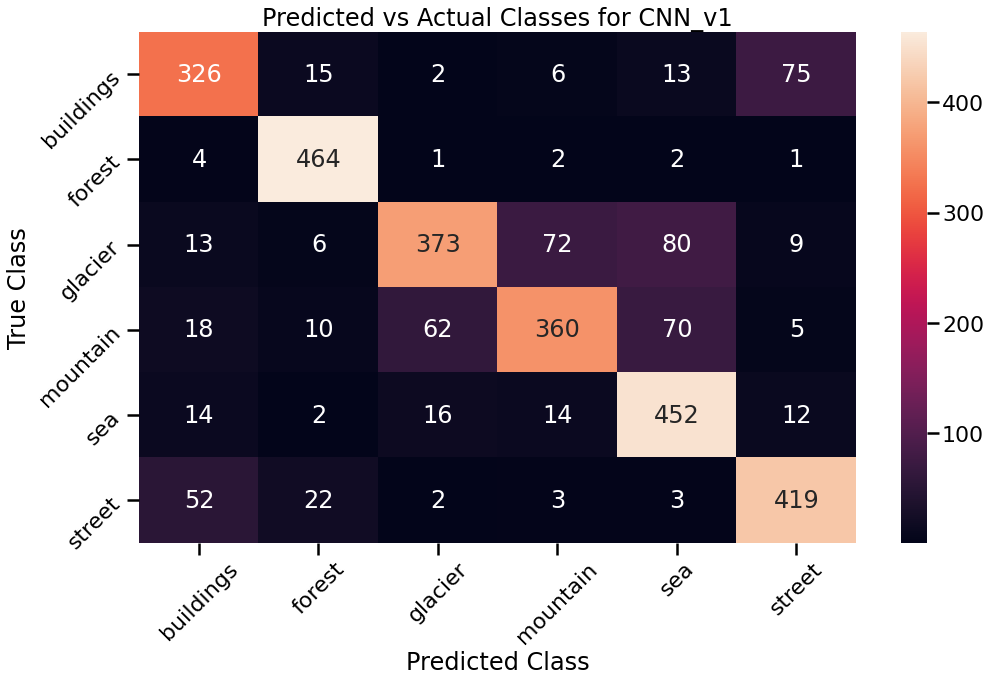